# Copernicus Marine for GFTS

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import intake
import hvplot.xarray  # noqa

In [2]:
# catalog_url specifies the URL for the catalog for reference data used.
catalog_url = "https://data-taos.ifremer.fr/kerchunk/ref-copernicus.yaml"

## Open intake catalog

In [3]:
cat = intake.open_catalog(catalog_url)

## Get model data

- Data model is read as Xarray Dataset e.g. only metadata is loaded in memory.

In [4]:
chunks = {"lat": -1, "lon": -1, "depth": 11, "time": 8}

### Get Temperature

In [5]:
model = cat.data(type="TEM", chunks=chunks).to_dask()
model

/srv/conda/envs/notebook/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 13TB
Dimensions:  (depth: 33, lat: 1240, lon: 958, time: 41952)
Coordinates:
  * depth    (depth) float32 132B 0.0 3.0 5.0 10.0 ... 2e+03 3e+03 4e+03 5e+03
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
  * time     (time) datetime64[ns] 336kB 2019-01-01T01:00:00 ... 2023-10-15
Data variables:
    thetao   (time, depth, lat, lon) float64 13TB dask.array<chunksize=(8, 11, 1240, 958), meta=np.ndarray>
Attributes: (12/13)
    Conventions:          CF-1.7
    contact:              servicedesk.cmems@mercator-ocean.eu
    creation_date:        2020-09-30T00:08:59Z
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); UKMO NATL12;...
    history:              See source and creation_date attributes
    ...                   ...
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    netcdf-version-id:    netCDF-4
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    references:           http://marine.copernicus.eu/
    source:               PS-OS 44, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    title:                hourly-instantaneous potential temperature (3D)

## Standardize metadata 
- We change the metadata of the dataset to make it easier for end-users

### Rename variables

In [6]:
model = model.rename({"thetao": "TEMP"})
model

<xarray.Dataset> Size: 13TB
Dimensions:  (depth: 33, lat: 1240, lon: 958, time: 41952)
Coordinates:
  * depth    (depth) float32 132B 0.0 3.0 5.0 10.0 ... 2e+03 3e+03 4e+03 5e+03
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
  * time     (time) datetime64[ns] 336kB 2019-01-01T01:00:00 ... 2023-10-15
Data variables:
    TEMP     (time, depth, lat, lon) float64 13TB dask.array<chunksize=(8, 11, 1240, 958), meta=np.ndarray>
Attributes: (12/13)
    Conventions:          CF-1.7
    contact:              servicedesk.cmems@mercator-ocean.eu
    creation_date:        2020-09-30T00:08:59Z
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); UKMO NATL12;...
    history:              See source and creation_date attributes
    ...                   ...
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    netcdf-version-id:    netCDF-4
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    references:           http://marine.copernicus.eu/
    source:               PS-OS 44, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    title:                hourly-instantaneous potential temperature (3D)

### Get other model variables into our dataset

- **XE**: Sea surface height above geoid
- **HO**: Bathymetry
- **mask**: Land-Sea mask

In [7]:
model = model.assign(
    {
        "XE": cat.data(type="SSH", chunks=chunks).to_dask().get("zos"),
        "H0": (
            cat.data_tmp(type="mdt", chunks=chunks)
            .to_dask()
            .get("deptho")
            .rename({"latitude": "lat", "longitude": "lon"})
        ),
        "mask": (
            cat.data_tmp(type="mdt", chunks=chunks)
            .to_dask()
            .get("mask")
            .rename({"latitude": "lat", "longitude": "lon"})
        ),
    }
)
model

/srv/conda/envs/notebook/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "depth" starting at index 11. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<xarray.Dataset> Size: 14TB
Dimensions:  (depth: 33, lat: 1240, lon: 958, time: 41952)
Coordinates:
  * depth    (depth) float32 132B 0.0 3.0 5.0 10.0 ... 2e+03 3e+03 4e+03 5e+03
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
  * time     (time) datetime64[ns] 336kB 2019-01-01T01:00:00 ... 2023-10-15
Data variables:
    TEMP     (time, depth, lat, lon) float64 13TB dask.array<chunksize=(8, 11, 1240, 958), meta=np.ndarray>
    XE       (time, lat, lon) float64 399GB dask.array<chunksize=(8, 1240, 958), meta=np.ndarray>
    H0       (lat, lon) float32 5MB dask.array<chunksize=(620, 479), meta=np.ndarray>
    mask     (depth, lat, lon) float32 157MB dask.array<chunksize=(11, 1240, 958), meta=np.ndarray>
Attributes: (12/13)
    Conventions:          CF-1.7
    contact:              servicedesk.cmems@mercator-ocean.eu
    creation_date:        2020-09-30T00:08:59Z
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); UKMO NATL12;...
    history:              See source and creation_date attributes
    ...                   ...
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    netcdf-version-id:    netCDF-4
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    references:           http://marine.copernicus.eu/
    source:               PS-OS 44, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    title:                hourly-instantaneous potential temperature (3D)

### Compute Dynamic depth and dynamic bathymetry
- Apply a simple formula and set the attributes (metadata) accordingly

In [8]:
model = model.assign(
    {
        "dynamic_depth": lambda ds: (ds["depth"] + ds["XE"]).assign_attrs(
            {
                "units": "m",
                "positive": "down",
                "long_name": "Dynamic Depth",
                "standard_name": "dynamic_depth",
            }
        ),
        "dynamic_bathymetry": lambda ds: (ds["H0"] + ds["XE"]).assign_attrs(
            {
                "units": "m",
                "positive": "down",
                "long_name": "Dynamic Bathymetry",
                "standard_name": "dynamic_bathymetry",
            }
        ),
    }
)

## What is xarray?

Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like multi-dimensional arrays, which allows for a more intuitive, more concise, and less error-prone developer experience.

### How is xarray structured?

Xarray has two core data structures, which build upon and extend the core strengths of NumPy and Pandas libraries. Both data structures are fundamentally N-dimensional:

- [DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html#xarray.DataArray) is the implementation of a labeled, N-dimensional array. It is an N-D generalization of a Pandas.Series. The name DataArray itself is borrowed from [Fernando Perez’s datarray project](http://fperez.org/py4science/datarray/), which prototyped a similar data structure.

- [Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html#xarray.Dataset) is a multi-dimensional, in-memory array database. It is a dict-like container of DataArray objects aligned along any number of shared dimensions, and serves a similar purpose in xarray as the pandas.DataFrame.


In [9]:
model

<xarray.Dataset> Size: 27TB
Dimensions:             (depth: 33, lat: 1240, lon: 958, time: 41952)
Coordinates:
  * depth               (depth) float32 132B 0.0 3.0 5.0 ... 3e+03 4e+03 5e+03
  * lat                 (lat) float32 5kB 46.0 46.01 46.03 ... 62.72 62.73 62.74
  * lon                 (lon) float32 4kB -16.0 -15.97 -15.94 ... 12.97 13.0
  * time                (time) datetime64[ns] 336kB 2019-01-01T01:00:00 ... 2...
Data variables:
    TEMP                (time, depth, lat, lon) float64 13TB dask.array<chunksize=(8, 11, 1240, 958), meta=np.ndarray>
    XE                  (time, lat, lon) float64 399GB dask.array<chunksize=(8, 1240, 958), meta=np.ndarray>
    H0                  (lat, lon) float32 5MB dask.array<chunksize=(620, 479), meta=np.ndarray>
    mask                (depth, lat, lon) float32 157MB dask.array<chunksize=(11, 1240, 958), meta=np.ndarray>
    dynamic_depth       (depth, time, lat, lon) float64 13TB dask.array<chunksize=(33, 8, 1240, 958), meta=np.ndarray>
    dynamic_bathymetry  (lat, lon, time) float64 399GB dask.array<chunksize=(620, 479, 8), meta=np.ndarray>
Attributes: (12/13)
    Conventions:          CF-1.7
    contact:              servicedesk.cmems@mercator-ocean.eu
    creation_date:        2020-09-30T00:08:59Z
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); UKMO NATL12;...
    history:              See source and creation_date attributes
    ...                   ...
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    netcdf-version-id:    netCDF-4
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    references:           http://marine.copernicus.eu/
    source:               PS-OS 44, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    title:                hourly-instantaneous potential temperature (3D)

## Accessing Coordinates and Data Variables 
DataArray, within Datasets, can be accessed through:
- the dot notation like Dataset.NameofVariable  
- or using square brackets, like Dataset['NameofVariable'] (NameofVariable needs to be a string so use quotes or double quotes)

In [10]:
model.TEMP

<xarray.DataArray 'TEMP' (time: 41952, depth: 33, lat: 1240, lon: 958)> Size: 13TB
dask.array<open_dataset-thetao, shape=(41952, 33, 1240, 958), dtype=float64, chunksize=(8, 11, 1240, 958), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 132B 0.0 3.0 5.0 10.0 ... 2e+03 3e+03 4e+03 5e+03
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
  * time     (time) datetime64[ns] 336kB 2019-01-01T01:00:00 ... 2023-10-15
Attributes:
    long_name:      Sea Water Potential Temperature
    standard_name:  sea_water_potential_temperature
    units:          degrees_C
    valid_max:      30000
    valid_min:      -30000

In [11]:
model["TEMP"]

<xarray.DataArray 'TEMP' (time: 41952, depth: 33, lat: 1240, lon: 958)> Size: 13TB
dask.array<open_dataset-thetao, shape=(41952, 33, 1240, 958), dtype=float64, chunksize=(8, 11, 1240, 958), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 132B 0.0 3.0 5.0 10.0 ... 2e+03 3e+03 4e+03 5e+03
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
  * time     (time) datetime64[ns] 336kB 2019-01-01T01:00:00 ... 2023-10-15
Attributes:
    long_name:      Sea Water Potential Temperature
    standard_name:  sea_water_potential_temperature
    units:          degrees_C
    valid_max:      30000
    valid_min:      -30000

Same can view the attributes only with DataArray.attrs ; this will return a dictionary.

In [12]:
model.TEMP.attrs

{'long_name': 'Sea Water Potential Temperature',
 'standard_name': 'sea_water_potential_temperature',
 'units': 'degrees_C',
 'valid_max': 30000,
 'valid_min': -30000}

## Check metadata of each variable

In [13]:
model.TEMP

<xarray.DataArray 'TEMP' (time: 41952, depth: 33, lat: 1240, lon: 958)> Size: 13TB
dask.array<open_dataset-thetao, shape=(41952, 33, 1240, 958), dtype=float64, chunksize=(8, 11, 1240, 958), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 132B 0.0 3.0 5.0 10.0 ... 2e+03 3e+03 4e+03 5e+03
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
  * time     (time) datetime64[ns] 336kB 2019-01-01T01:00:00 ... 2023-10-15
Attributes:
    long_name:      Sea Water Potential Temperature
    standard_name:  sea_water_potential_temperature
    units:          degrees_C
    valid_max:      30000
    valid_min:      -30000

In [14]:
model.XE

<xarray.DataArray 'XE' (time: 41952, lat: 1240, lon: 958)> Size: 399GB
dask.array<open_dataset-zos, shape=(41952, 1240, 958), dtype=float64, chunksize=(8, 1240, 958), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
  * time     (time) datetime64[ns] 336kB 2019-01-01T01:00:00 ... 2023-10-15
Attributes:
    long_name:      Sea surface height above geoid
    standard_name:  sea_surface_height_above_geoid
    units:          m
    valid_max:      10000
    valid_min:      -10000

In [15]:
model.H0

<xarray.DataArray 'H0' (lat: 1240, lon: 958)> Size: 5MB
dask.array<open_dataset-deptho, shape=(1240, 958), dtype=float32, chunksize=(620, 479), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
Attributes:
    long_name:      Bathymetry
    standard_name:  sea_floor_depth_below_geoid
    units:          m

In [16]:
model.mask

<xarray.DataArray 'mask' (depth: 33, lat: 1240, lon: 958)> Size: 157MB
dask.array<open_dataset-mask, shape=(33, 1240, 958), dtype=float32, chunksize=(11, 1240, 958), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 132B 0.0 3.0 5.0 10.0 ... 2e+03 3e+03 4e+03 5e+03
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
Attributes:
    long_name:      Land-sea mask: sea = 1 ; land = 0
    standard_name:  sea_binary_mask
    units:          1

In [17]:
model.dynamic_depth

<xarray.DataArray 'dynamic_depth' (depth: 33, time: 41952, lat: 1240, lon: 958)> Size: 13TB
dask.array<add, shape=(33, 41952, 1240, 958), dtype=float64, chunksize=(33, 8, 1240, 958), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 132B 0.0 3.0 5.0 10.0 ... 2e+03 3e+03 4e+03 5e+03
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
  * time     (time) datetime64[ns] 336kB 2019-01-01T01:00:00 ... 2023-10-15
Attributes:
    units:          m
    positive:       down
    long_name:      Dynamic Depth
    standard_name:  dynamic_depth

In [18]:
model.dynamic_bathymetry

<xarray.DataArray 'dynamic_bathymetry' (lat: 1240, lon: 958, time: 41952)> Size: 399GB
dask.array<add, shape=(1240, 958, 41952), dtype=float64, chunksize=(620, 479, 8), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
  * time     (time) datetime64[ns] 336kB 2019-01-01T01:00:00 ... 2023-10-15
Attributes:
    units:          m
    positive:       down
    long_name:      Dynamic Bathymetry
    standard_name:  dynamic_bathymetry

### Xarray and Memory usage

Once a Data Array|Set is opened, xarray loads into memory only the coordinates and all the metadata needed to describe it.
The underlying data, the component written into the datastore, are loaded into memory as a NumPy array, only once directly accessed; once in there, it will be kept to avoid re-readings.
This brings the fact that it is good practice to have a look to the size of the data before accessing it. A classical mistake is to try loading arrays bigger than the memory with the obvious result of killing a notebook Kernel or Python process.
If the dataset does not fit in the available memory, then the only option will be to load it through the chunking; later on, in the tutorial 'chunking_introduction', we will introduce this concept.

As the size of the data is too big to fit into memory, we need to chunk the data (and this is where we can use `dask` to parallelise.

In [19]:
model.TEMP.data

dask.array<open_dataset-thetao, shape=(41952, 33, 1240, 958), dtype=float64, chunksize=(8, 11, 1240, 958), chunktype=numpy.ndarray>

## Select and Plot

As it is not easy to remember the order of dimensions, Xarray really helps by making it possible to select the position using names:

.isel -> selection based on positional index
.sel -> selection based on coordinate values

In [20]:
model.TEMP.isel(time=0, depth=0)

<xarray.DataArray 'TEMP' (lat: 1240, lon: 958)> Size: 10MB
dask.array<getitem, shape=(1240, 958), dtype=float64, chunksize=(1240, 958), chunktype=numpy.ndarray>
Coordinates:
    depth    float32 4B 0.0
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
    time     datetime64[ns] 8B 2019-01-01T01:00:00
Attributes:
    long_name:      Sea Water Potential Temperature
    standard_name:  sea_water_potential_temperature
    units:          degrees_C
    valid_max:      30000
    valid_min:      -30000

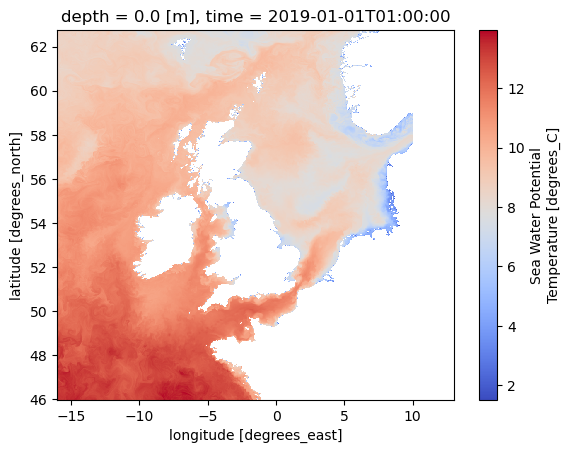

In [21]:
model.TEMP.isel(time=0, depth=0).plot(cmap="coolwarm")

### Reproject data 
- See https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html for more details on different available projections

Text(0.5, 1.0, 'Copernicus Marine')

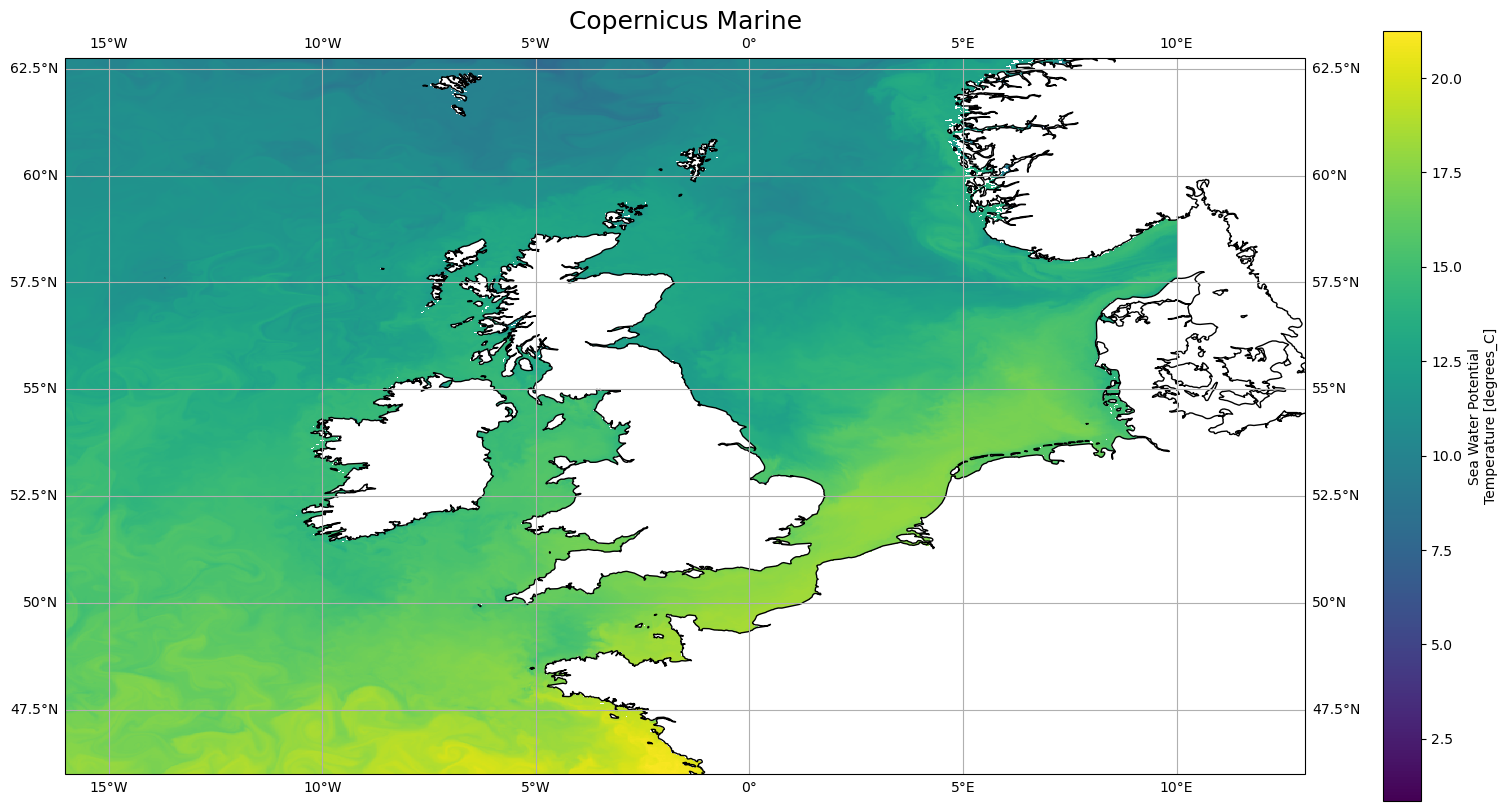

In [22]:
fig = plt.figure(1, figsize=[20, 10])

# We're using cartopy and are plotting in PlateCarree projection
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines(resolution="10m")
ax.gridlines(draw_labels=True)

model["TEMP"].sel(time="2023-10-14T22:00:00.000000000").isel(depth=0).plot(
    ax=ax, transform=ccrs.PlateCarree()
)

# One way to customize your title
plt.title("Copernicus Marine", fontsize=18)

Text(0.5, 1.0, 'Copernicus Marine')

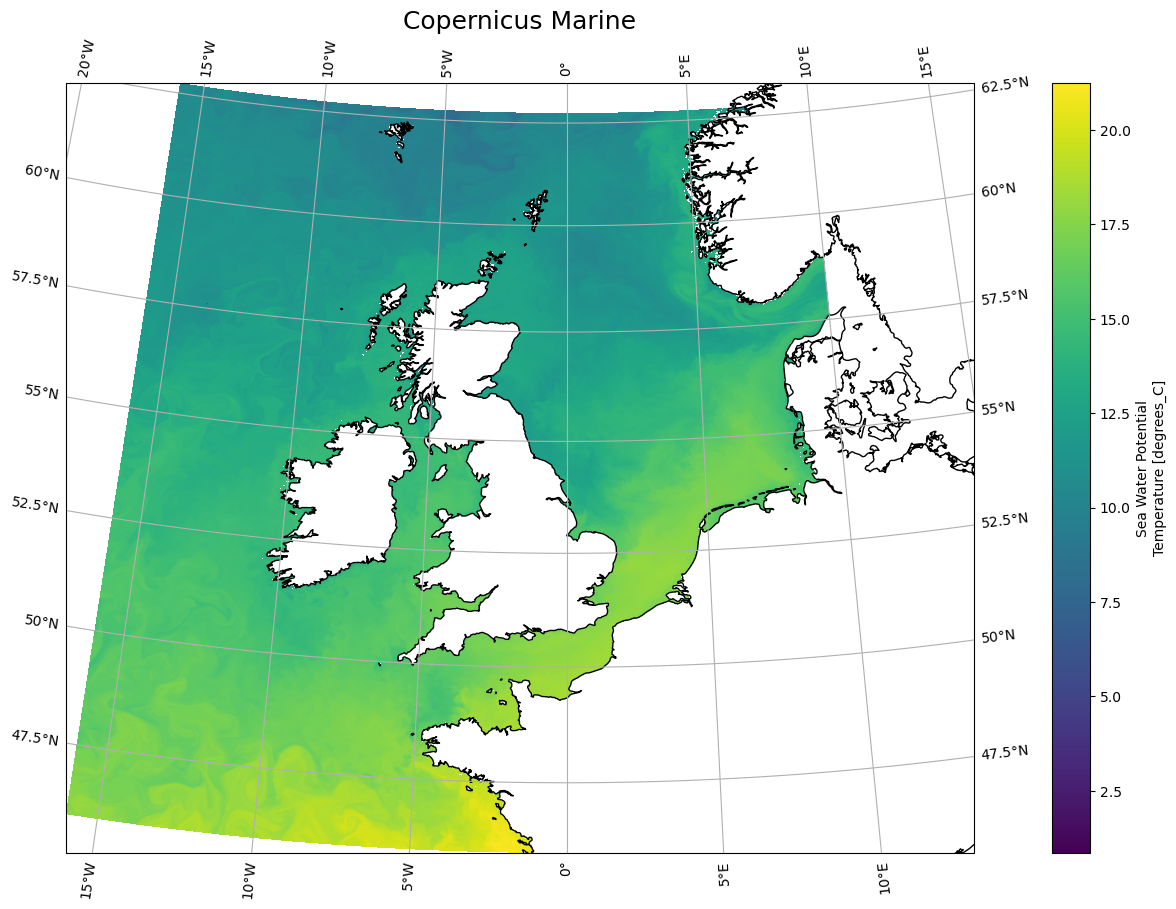

In [23]:
fig = plt.figure(1, figsize=[20, 10])

# We're using cartopy and are plotting in PlateCarree projection
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.AlbersEqualArea())
ax.coastlines(resolution="10m")
ax.gridlines(draw_labels=True)

model["TEMP"].sel(time="2023-10-14T22:00:00.000000000").isel(depth=0).plot(
    ax=ax, transform=ccrs.PlateCarree()
)

# One way to customize your title
plt.title("Copernicus Marine", fontsize=18)

### Interactive visualization with holoviews

In [27]:
model.isel(time=0, depth=0).hvplot(cmap="coolwarm", width=1000, height=1000)

Having a look to data distribution can reveal a lot about the data.

In [28]:
model["TEMP"][0].hvplot.hist(cmap="coolwarm", bins=25, width=800, height=700)

### Multi-plots using groupby

To be able to visualize interactively all the different available times, we can use groupby time.

In [30]:
model["TEMP"].isel(depth=0).hvplot(
    groupby="time", cmap="coolwarm", width=800, height=700
)